Starting VAE training...
Epoch 1/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.7028 - val_loss: 0.6450
Epoch 2/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5523 - val_loss: 0.3468
Epoch 3/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2606 - val_loss: 0.0546
Epoch 4/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0441 - val_loss: 0.0268
Epoch 5/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0241 - val_loss: 0.0180
Epoch 6/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0165 - val_loss: 0.0131
Epoch 7/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 8/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0096 - val_loss: 0.0082
Epoch 9/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 10/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0066 - val_loss: 0.0059
Epoch 11/5000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 12/5000
63

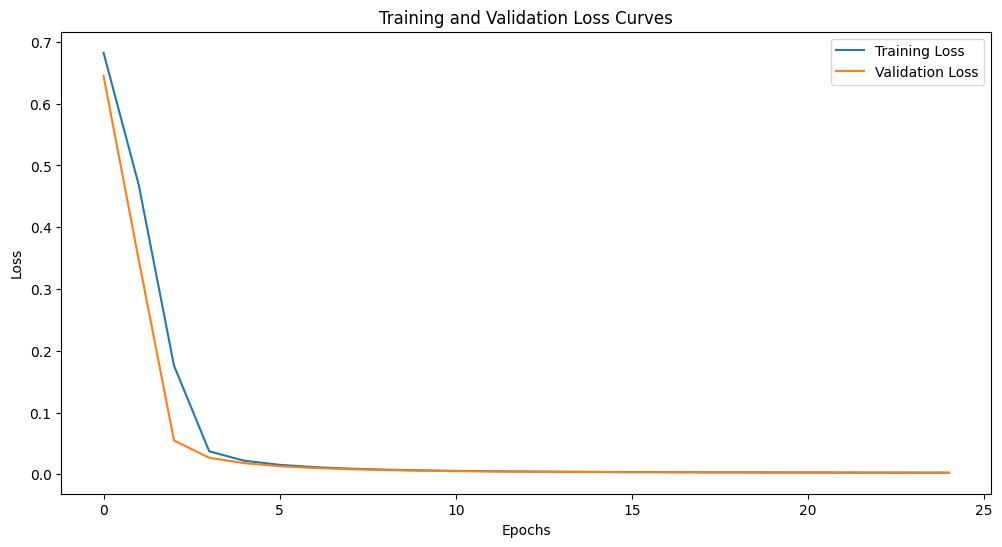

In [52]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
from datetime import datetime
import pandas as pd
from tensorflow.keras.utils import plot_model

# Define hyperparameters
latent_dim = 500
epochs = 5000
batch_size = 32000
learning_rate = 0.0001
delta_loss = 0.002

# Load the data
IQ_x_tuple = np.load('dataset/sent_data_tuple.npy') # Dataset with the original data
IQ_y_tuple = np.load('dataset/received_data_tuple_sync-phase.npy')  #Dataset Normalized and phase-synchronized

# Load the new data
IQ_x_tuple2 = np.load('dataset/sent_data_tuple2.npy') #Sent dataset with different caracteristics to test the model
IQ_y_tuple2 = np.load('dataset/received_data_tuple_sync-phase2.npy') #Received dataset with different caracteristics to test the model

# # Dividir os datasets pela metade
# mid_point = len(IQ_x_tuple) // 2

# IQ_x_tuple = IQ_x_tuple[:mid_point]
# IQ_y_tuple = IQ_y_tuple[:mid_point]

# IQ_x_tuple2 = IQ_x_tuple2[:mid_point]
# IQ_y_tuple2 = IQ_y_tuple2[:mid_point]

# Encoder
def build_encoder(latent_dim, input_dim=2):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.00))(inputs)
    x = layers.Dense(128, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.00))(x)
    x = layers.Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.00))(x)
    x = layers.Dense(32, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.00))(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    model = models.Model(inputs, [z_mean, z_log_var], name='encoder')
    return model, z_mean, z_log_var

# Decoder
def build_decoder(latent_dim, output_dim=2):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.00))(latent_inputs)
    x = layers.Dense(64, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.00))(x)
    x = layers.Dense(128, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.00))(x)
    x = layers.Dense(256, activation='leaky_relu', kernel_regularizer=regularizers.l2(0.00))(x)
    outputs = layers.Dense(output_dim, activation='linear')(x)
    model = models.Model(latent_inputs, outputs, name='decoder')
    return model

# Sampling function for VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Custom loss function for VAE
def custom_iq_loss(y_true, y_pred):
    y_true_complex = tf.complex(y_true[:, 0], y_true[:, 1])
    y_pred_complex = tf.complex(y_pred[:, 0], y_pred[:, 1])
    error_magnitude = tf.abs(y_true_complex - y_pred_complex)
    return tf.reduce_mean(tf.square(error_magnitude))

# Assemble the model
encoder, z_mean, z_log_var = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(IQ_x_tuple, IQ_y_tuple, test_size=0.2, random_state=52)

# Compile and train the VAE
vae_inputs = encoder.input
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
vae_outputs = decoder(z)
vae = models.Model(vae_inputs, vae_outputs, name='vae')
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=custom_iq_loss)

# Define the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=delta_loss, restore_best_weights=True)

# Train the VAE
print("Starting VAE training...")
history = vae.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), callbacks=[early_stopping])
print("VAE training completed.")

real_epochs = len(history.history['loss'])

# Save the loss curves for training and validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()


In [53]:
# Save the trained VAE model
tf.saved_model.save(vae, 'vae_model_savedmodel_5MS_100kS_Square')
print("Model saved as 'vae_model_savedmodel_5MS_100kS_Square'")


INFO:tensorflow:Assets written to: vae_model_savedmodel_5MS_100kS_Square/assets


INFO:tensorflow:Assets written to: vae_model_savedmodel_5MS_100kS_Square/assets


Model saved as 'vae_model_savedmodel_5MS_100kS_Square'


Model file found.
Model successfully loaded.
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 8s 483us/step
78125/78125 ━━━━━━━━━━━━━━━━━━━━ 36s 456us/step


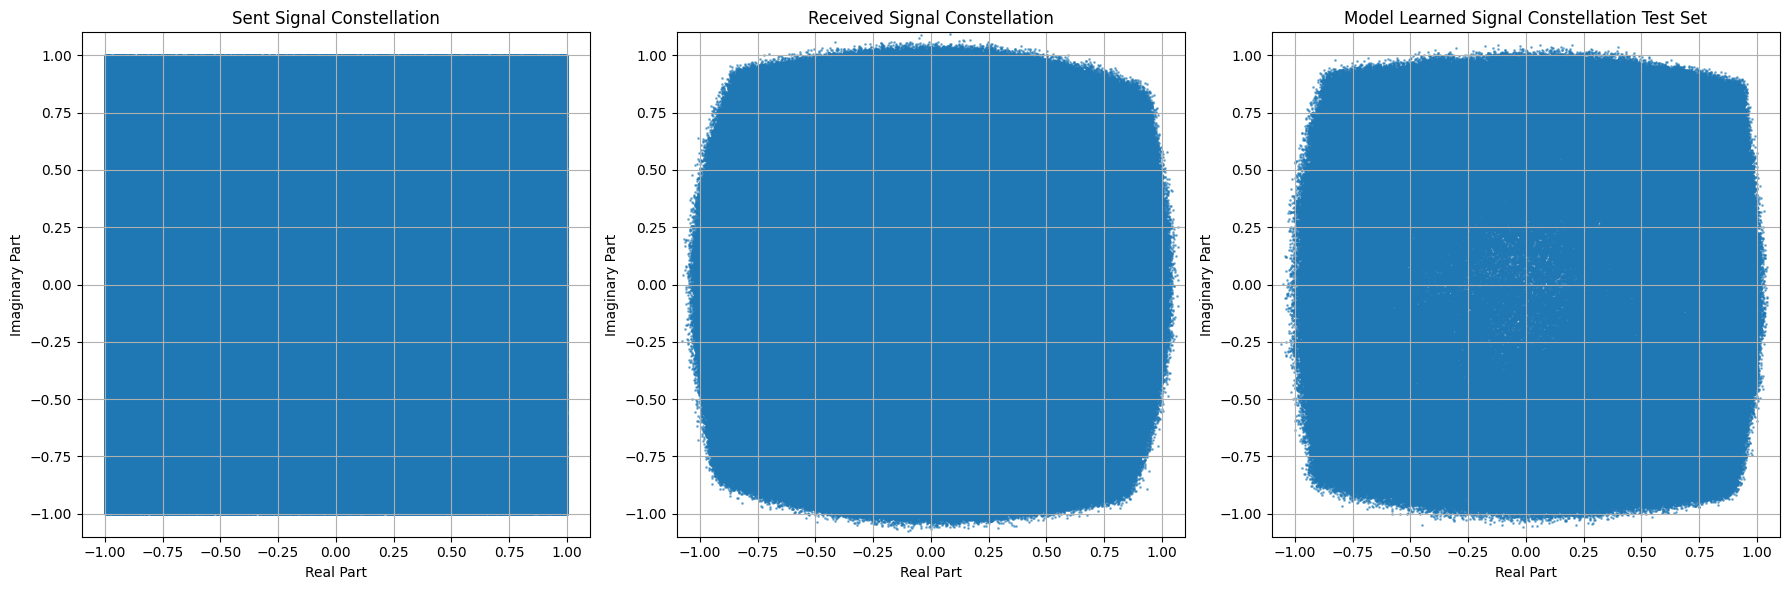

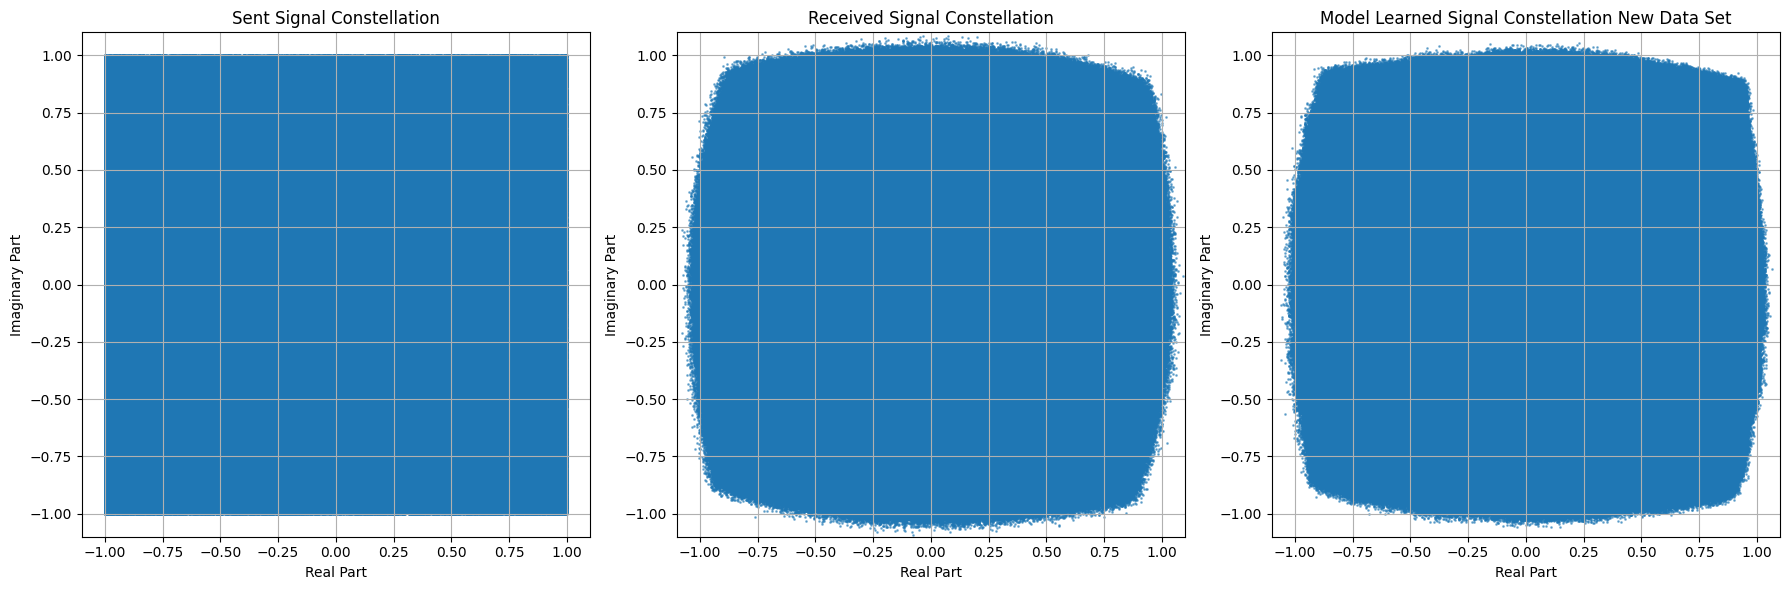

In [54]:

# Load saved VAE model # That model was created in the main VAE code.
model_path = 'vae_model_savedmodel_5MS_100kS_Square'
if os.path.exists(model_path):
    print("Model file found.")
    try:
        vae_loaded = tf.keras.layers.TFSMLayer(model_path, call_endpoint='serving_default')
        print("Model successfully loaded.")
    except Exception as e:
        print(f"Error loading the model: {e}")
        traceback.print_exc()
        vae_loaded = None
else:
    print("Model file not found. Please check the file path.")
    vae_loaded = None

# Generate predictions for Y from X using the trained model
Y_pred = vae.predict(X_test)
Y_pred_new = vae.predict(IQ_x_tuple2)

# Function to plot constellations
def plot_constellations(IQ_x, IQ_y, Y_pred, title_suffix):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    def plot_constellation(data_complex, title, ax):
        data_complex = np.array(data_complex)
        ax.scatter(data_complex[:, 0], data_complex[:, 1], s=1, alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('Real Part')
        ax.set_ylabel('Imaginary Part')
        ax.grid(True)
        ax.set_xlim(axis_limits)
        ax.set_ylim(axis_limits)
    plot_constellation(IQ_x, "Sent Signal Constellation", axs[0])
    plot_constellation(IQ_y, "Received Signal Constellation", axs[1])
    plot_constellation(Y_pred, f"Model Learned Signal Constellation {title_suffix}", axs[2])
    plt.tight_layout()
    plt.show()

axis_limits = [-1.1, 1.1]

# Plot constellations
plot_constellations(IQ_x_tuple, IQ_y_tuple, Y_pred, "Test Set")
plot_constellations(IQ_x_tuple2, IQ_y_tuple2, Y_pred_new, "New Data Set")

# Function to calculate EVM
def calculate_evm(reference_signal, test_signal):
    reference_complex = reference_signal[:, 0] + 1j * reference_signal[:, 1]
    test_complex = test_signal[:, 0] + 1j * test_signal[:, 1]
    error_vector = test_complex - reference_complex
    error_magnitude = np.abs(error_vector)
    average_power = np.mean(np.abs(reference_complex)**2)
    EVM = np.sqrt(np.mean(error_magnitude**2) / average_power)
    EVM_percentage = EVM * 100
    EVM_dB = 20 * np.log10(EVM)
    return EVM_percentage, EVM_dB

# Function to estimate noise power.
def calculate_noise_power(sent, received):
    noise = received - sent  # Sinal de ruído
    noise_power = np.mean(np.abs(noise)**2, axis=0)  # Potência do ruído para I e Q
    total_noise_power = np.sum(noise_power)  # Potência total do ruído
    return total_noise_power





In [62]:
# Calculate EVM
EVM_percentage_original, EVM_dB_original = calculate_evm(IQ_x_tuple, IQ_y_tuple) #EVM between originally sent and received
EVM_percentage_learned, EVM_dB_learned = calculate_evm(X_test, Y_pred) #EVM between originally sent and model learned.
EVM_difference = EVM_percentage_learned - EVM_percentage_original #Error in EVM

# Calculate EVM for new data set
EVM_percentage_new_original, EVM_dB_new_original = calculate_evm(IQ_x_tuple2, IQ_y_tuple2) #EVM between originally sent and received for new data set
EVM_percentage_new_learned, EVM_dB_new_learned = calculate_evm(IQ_x_tuple2, Y_pred_new) # EVM between originally sent and model learned for new data set
EVM_difference_new = EVM_percentage_new_learned - EVM_percentage_new_original #Error in EVM for new data set
EVM_dB_difference_new = EVM_dB_new_learned - EVM_dB_new_original #Error in EVM for new data set
EVM_dB_difference = EVM_dB_learned - EVM_dB_original #Error in EVM

# Display EVM results
print(f"EVM between originally sent and received (%): {EVM_percentage_original}, dB: {EVM_dB_original}")
print(f"EVM between originally sent and model learned (test set) (%): {EVM_percentage_learned}, dB: {EVM_dB_learned}")
print(f"Difference in EVM (%): {EVM_difference}, dB: {EVM_dB_difference}\n")
print(f"EVM between originally sent and received for new data set (%): {EVM_percentage_new_original}, dB: {EVM_dB_new_original}")
print(f"EVM between originally sent and model learned for new data set (%): {EVM_percentage_new_learned}, dB: {EVM_dB_new_learned}")
print(f"Difference in EVM and dB for new data set (%): {EVM_difference_new}, dB: {EVM_dB_difference_new}\n")


EVM between originally sent and received (%): 8.603543788194656, dB: -21.306452751159668
EVM between originally sent and model learned (test set) (%): 7.885972410440445, dB: -22.06289529800415
Difference in EVM (%): -0.7175713777542114, dB: -0.7564425468444824

EVM between originally sent and received for new data set (%): 7.615584135055542, dB: -22.3659348487854
EVM between originally sent and model learned for new data set (%): 7.877016067504883, dB: -22.072765827178955
Difference in EVM and dB for new data set (%): 0.2614319324493408, dB: 0.2931690216064453



In [56]:
# Cálculo da potência do ruído
noise_power_dataset1 = calculate_noise_power(IQ_x_tuple, IQ_y_tuple) #DATASET QUE FOI USADO PARA TREINAR O MODELO, POREM, DIVIDIU-SE EM TREINO E TESTE.
print(f'Noise power dataset1: {noise_power_dataset1:.6e}')

noise_power_dataset2 = calculate_noise_power(IQ_x_tuple2, IQ_y_tuple2) #DATASET QUE FOI USADO PARA TESTAR O MODELO.
print(f'Noise power dataset2: {noise_power_dataset2:.6e}')

noise_power_test_set = calculate_noise_power(X_test, Y_test)
print(f'Noise power test set: {noise_power_test_set:.6e}')

noise_power_learned_test_set = calculate_noise_power(X_test, Y_pred)
print(f'Noise power learned test set: {noise_power_learned_test_set:.6e}')

noise_power_learned = calculate_noise_power(IQ_x_tuple2, Y_pred_new)
print(f'Noise power learned dataset2: {noise_power_learned:.6e}')

noise_power_difference_test_set = noise_power_learned_test_set - noise_power_test_set
noise_power_difference = noise_power_learned - noise_power_dataset2
print(f'Difference in noise power test set: {noise_power_difference_test_set:.6e}')
print(f'Difference in noise power (dataset2 / learned): {noise_power_difference:.6e}')


Noise power dataset1: 4.923035e-03
Noise power dataset2: 3.860132e-03
Noise power test set: 4.943779e-03
Noise power learned test set: 4.140211e-03
Noise power learned dataset2: 4.126726e-03
Difference in noise power test set: -8.035679e-04
Difference in noise power (dataset2 / learned): 2.665934e-04


In [57]:
print(IQ_x_tuple.shape)
print(IQ_y_tuple.shape)

print(IQ_x_tuple2.shape)
print(IQ_y_tuple2.shape)

print(IQ_x_tuple[:5])
print(IQ_y_tuple[:5])

print(IQ_x_tuple2[:5])
print(IQ_y_tuple2[:5])

(2500000, 2)
(2500000, 2)
(2500000, 2)
(2500000, 2)
[[-0.23142186 -0.3014008 ]
 [ 0.7829829   0.82561725]
 [-0.8915372   0.90102845]
 [ 0.5648976   0.09158605]
 [-0.98370314  0.56755275]]
[[-0.2542425  -0.33625382]
 [ 0.7599137   0.77260303]
 [-0.77826846  0.8415037 ]
 [ 0.554877    0.15377623]
 [-0.8644371   0.57794017]]
[[ 0.897763   -0.56697285]
 [-0.63200784 -0.28662986]
 [ 0.6706442  -0.44489884]
 [-0.743614   -0.3400067 ]
 [-0.02179022  0.9853816 ]]
[[ 0.831085   -0.5434153 ]
 [-0.6169098  -0.32357052]
 [ 0.7230286  -0.4660694 ]
 [-0.74693656 -0.3400816 ]
 [-0.0389537   1.0284586 ]]
